# Run cellpose on a single file

In [1]:
input_file_path = '/home/ubuntu/2_01_417_1_5_4_coord_5904_1456.png'
outline_file_path = '/home/ubuntu/2_01_417_1_5_4_coord_5904_1456_outlined.png'
# we assume we make use of only one channel (DAPI) from the input
nuclei_channel = 1
mask_volume_threshold_of_max = 0.05
diameter = 30

In [2]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import torch
from cellpose import utils
import cellpose

from pathlib import Path

# use_GPU = utils.use_gpu()
# print('GPU activated? %d'%use_GPU)
from PIL import Image


In [3]:
assert Path(input_file_path).suffix in ['.png'], input_file_path

In [4]:
base_filename = Path(input_file_path).stem
base_filename

'2_01_417_1_5_4_coord_5904_1456'

## run cellpose on an input image

In [5]:
# swap axes so we have the (Z, channels, Y, X) shape
# TODO: make this automatic
data = np.array(Image.open(input_file_path).convert('RGB'))
data.shape

(512, 512, 3)

In [6]:
img = data
img.shape

(512, 512, 3)

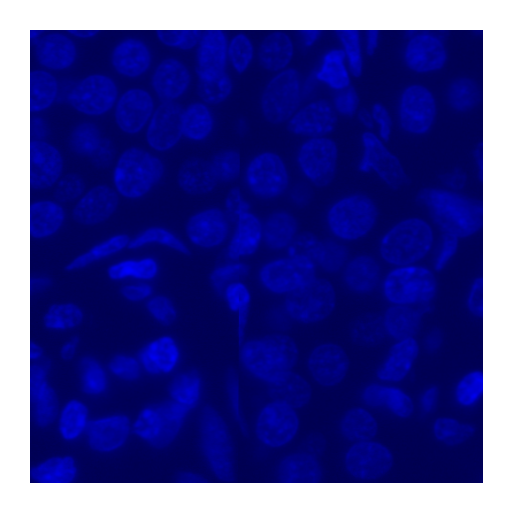

In [7]:
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
channels = [3,0] # 3 means blue channel here

In [9]:
# test 3D stack
from cellpose import models

In [10]:
%%time

model = models.Cellpose(gpu=True, model_type='cyto')

# in this example I'm using a random matrix, put your own data here
# data = np.random.randn(120,512,512).astype(np.float32)
# data = imread('/home/gkk/ada_lsm_test_squeeze.tif')

# with 3D you have to set the diameter manually (no auto detect)
#imgs, diameter=110, #flow_threshddold=, 
#                                         cellprob_threshold=0.5, resample=True,
#                                          flow_threshold=0.2,
#                                         stitch_threshold=0.4,
#                                         channels=channels
masks, flows, styles, diams = model.eval(img, channels=channels,
                                         diameter=diameter,
                                         resample=True,
                                         cellprob_threshold=0.5,
                                         flow_threshold=0.5)

TORCH CUDA version not installed/working.
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 30.88s; flow+mask computation 2.37
estimated masks for 1 image(s) in 33.27 sec
>>>> TOTAL TIME 33.27 sec
CPU times: user 1min, sys: 7.28 s, total: 1min 7s
Wall time: 33.4 s


In [11]:
masks.shape, img.shape

((512, 512), (512, 512, 3))

In [12]:
np.unique(masks)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101], dtype=int32)

In [13]:
len(flows)

4

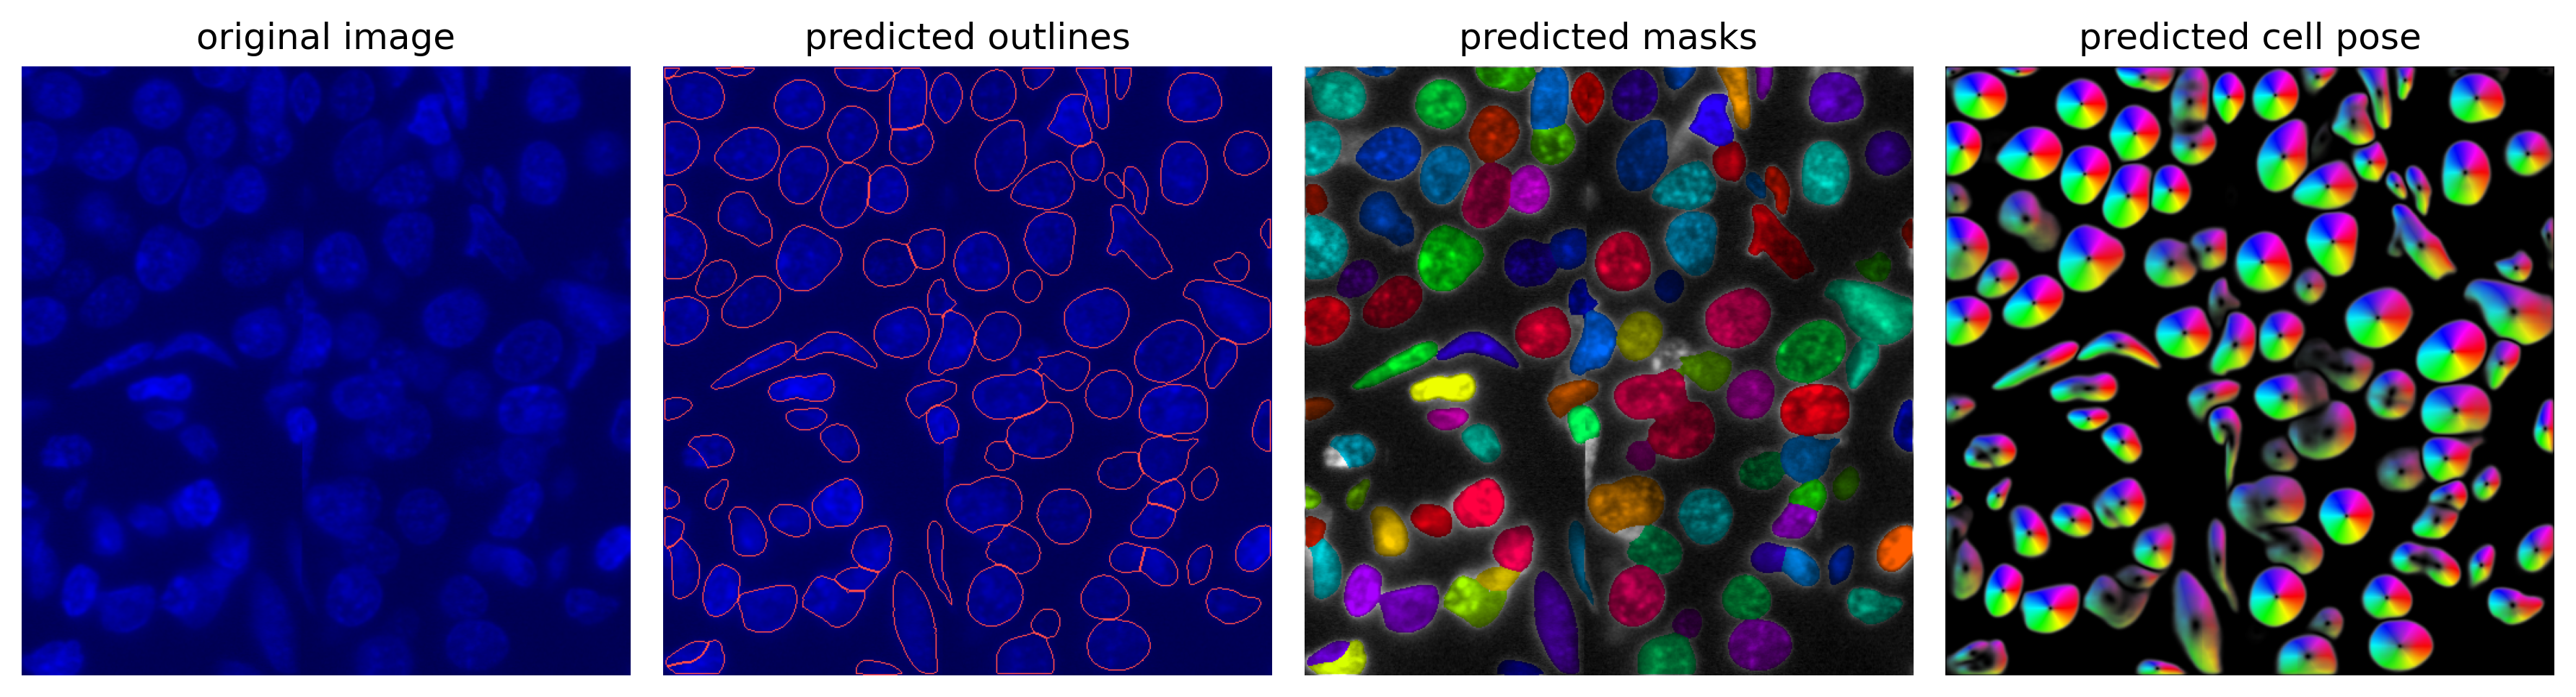

In [14]:
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

In [17]:
outlines = cellpose.utils.masks_to_outlines(masks)

In [18]:
# cellpose.plot.show_segmentation has an option to save the outline
# but for some reason messes up colors of the original image when
# outlined image is saved (weirdly, colors are preserved when displayed)
# I recreated it here to side-step that issue
def outline_image(img, masks):
    import cellpose.utils
    outlines = cellpose.utils.masks_to_outlines(masks)
    img_outlined = img.copy()
    outlinesX, outlinesY = np.nonzero(outlines)
    img_outlined[outlinesX, outlinesY] = np.array([255,75,75])
    return img_outlined

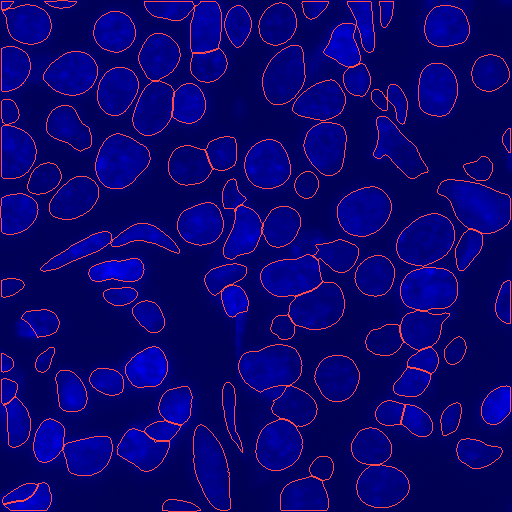

In [19]:
outlined_img = outline_image(img, masks)
Image.fromarray(outlined_img)

In [17]:
# outlined_img_file_path = f'{basedir_out}/segmentation_{base_filename}_outline.png'
# Image.fromarray(outlined_img).save(outlined_img_file_path)
# outlined_img_file_path

'.//segmentation_demo_outline.png'

In [20]:
Image.fromarray(outlined_img).save(outline_file_path)

## Remap mask ids
Remap mask ids to "compact" integers (from 0..len(unique_ids) range)

In [18]:
def compact_integer_values(a):
    uniqs = np.unique(a)
    max_value = uniqs.max()
    assert max_value < 100000, max_value # some reasonable threshold that assures we do not allocate unreasonable amounts of memory below
    compact_for_uniqs = np.zeros(uniqs.max()+1, dtype=np.int)
    compact_for_uniqs[uniqs] = range(len(uniqs)) # each uniq receives a new index from the range
    a_compact_values = compact_for_uniqs[a]
    return a_compact_values

In [19]:
masks = compact_integer_values(masks)

## Mask volume estimate through pixel counting

In [20]:
masks_orig = masks
masks = np.copy(masks_orig)

In [21]:
mask_indices, mask_volume = np.unique(masks,return_counts=True)
mask_indices, mask_volume = mask_indices[1:], mask_volume[1:] # zero is background so we drop it for volume analysis
mask_indices, mask_volume

(array([1, 2, 3, 4, 5, 6]), array([28360, 23803, 27732, 18559, 16456, 27987]))

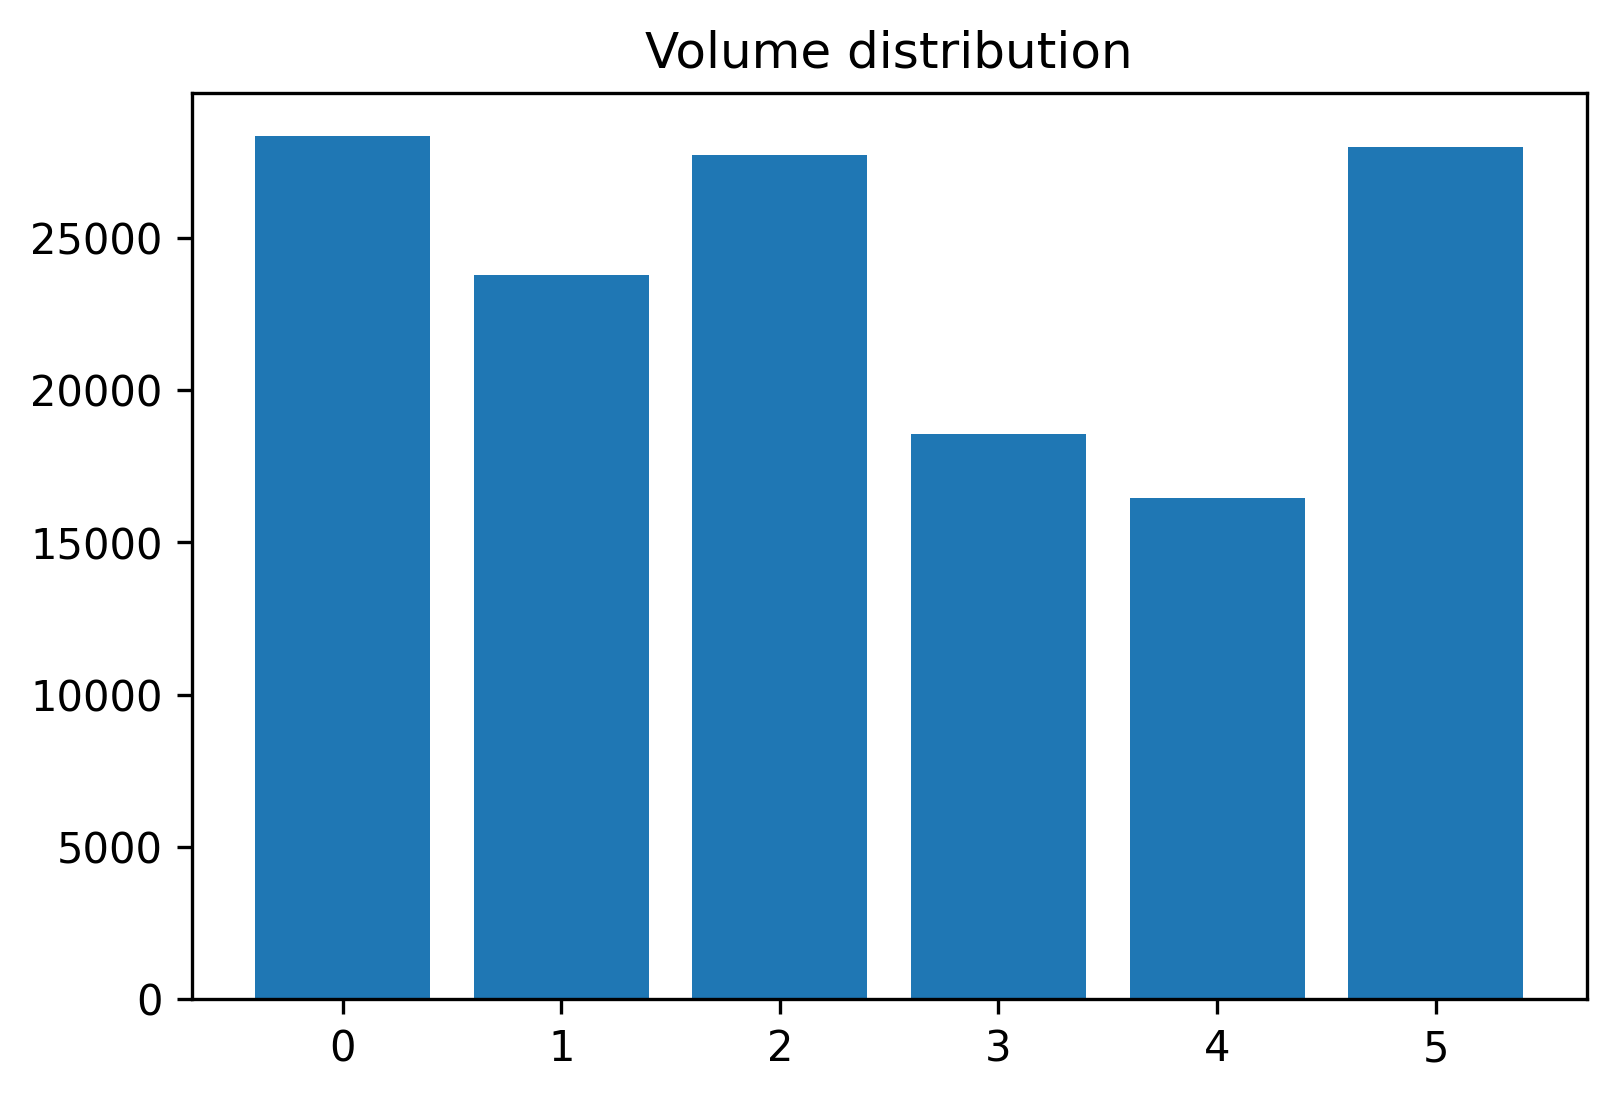

In [22]:
plt.bar(range(len(mask_volume)), mask_volume)
plt.title('Volume distribution')
plt.show()

In [23]:
mask_volume_threshold = mask_volume.max()*mask_volume_threshold_of_max
mask_volume_threshold

1418.0

In [24]:
np.sum(mask_volume > mask_volume_threshold)

6

In [25]:
masks_indices_above_threshold = mask_indices[mask_volume > mask_volume_threshold]

In [26]:
masks[np.isin(masks, masks_indices_above_threshold, invert=True)] = 0

In [27]:
np.unique(masks)

array([0, 1, 2, 3, 4, 5, 6])

In [28]:
compact_integer_values(masks)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
masks = masks_orig

Put the exploratory code from the above into a reusable function

In [30]:
from IPython.display import display
def zero_small_volume_masks(masks, mask_volume_threshold_of_max):
    mask_indices, mask_volume = np.unique(masks,return_counts=True)
    mask_indices, mask_volume = mask_indices[1:], mask_volume[1:] # zero is background so we drop it for volume analysis
    display(mask_indices, mask_volume)
    
    plt.bar(range(len(mask_volume)), mask_volume)
    plt.title('Volume distribution')
    plt.show()
    
    mask_volume_threshold = mask_volume.max()*mask_volume_threshold_of_max
    
    import pandas as pd
    df = pd.DataFrame(mask_volume, columns=['volume'])
    display(df)
    
    df['% of max'] = (df['volume'] / df['volume'].max() * 100).round(1)
    display(df)
    
    masks_indices_above_threshold = mask_indices[mask_volume > mask_volume_threshold]
    masks_large_only = np.copy(masks)
    masks_large_only[np.isin(masks_large_only, masks_indices_above_threshold, invert=True)] = 0
    
    masks_large_only = compact_integer_values(masks_large_only)
    
    display(np.unique(masks_large_only))
    
    return masks_large_only

### Remove small volume outliers

In [31]:
np.unique(masks)

array([0, 1, 2, 3, 4, 5, 6])

array([1, 2, 3, 4, 5, 6])

array([28360, 23803, 27732, 18559, 16456, 27987])

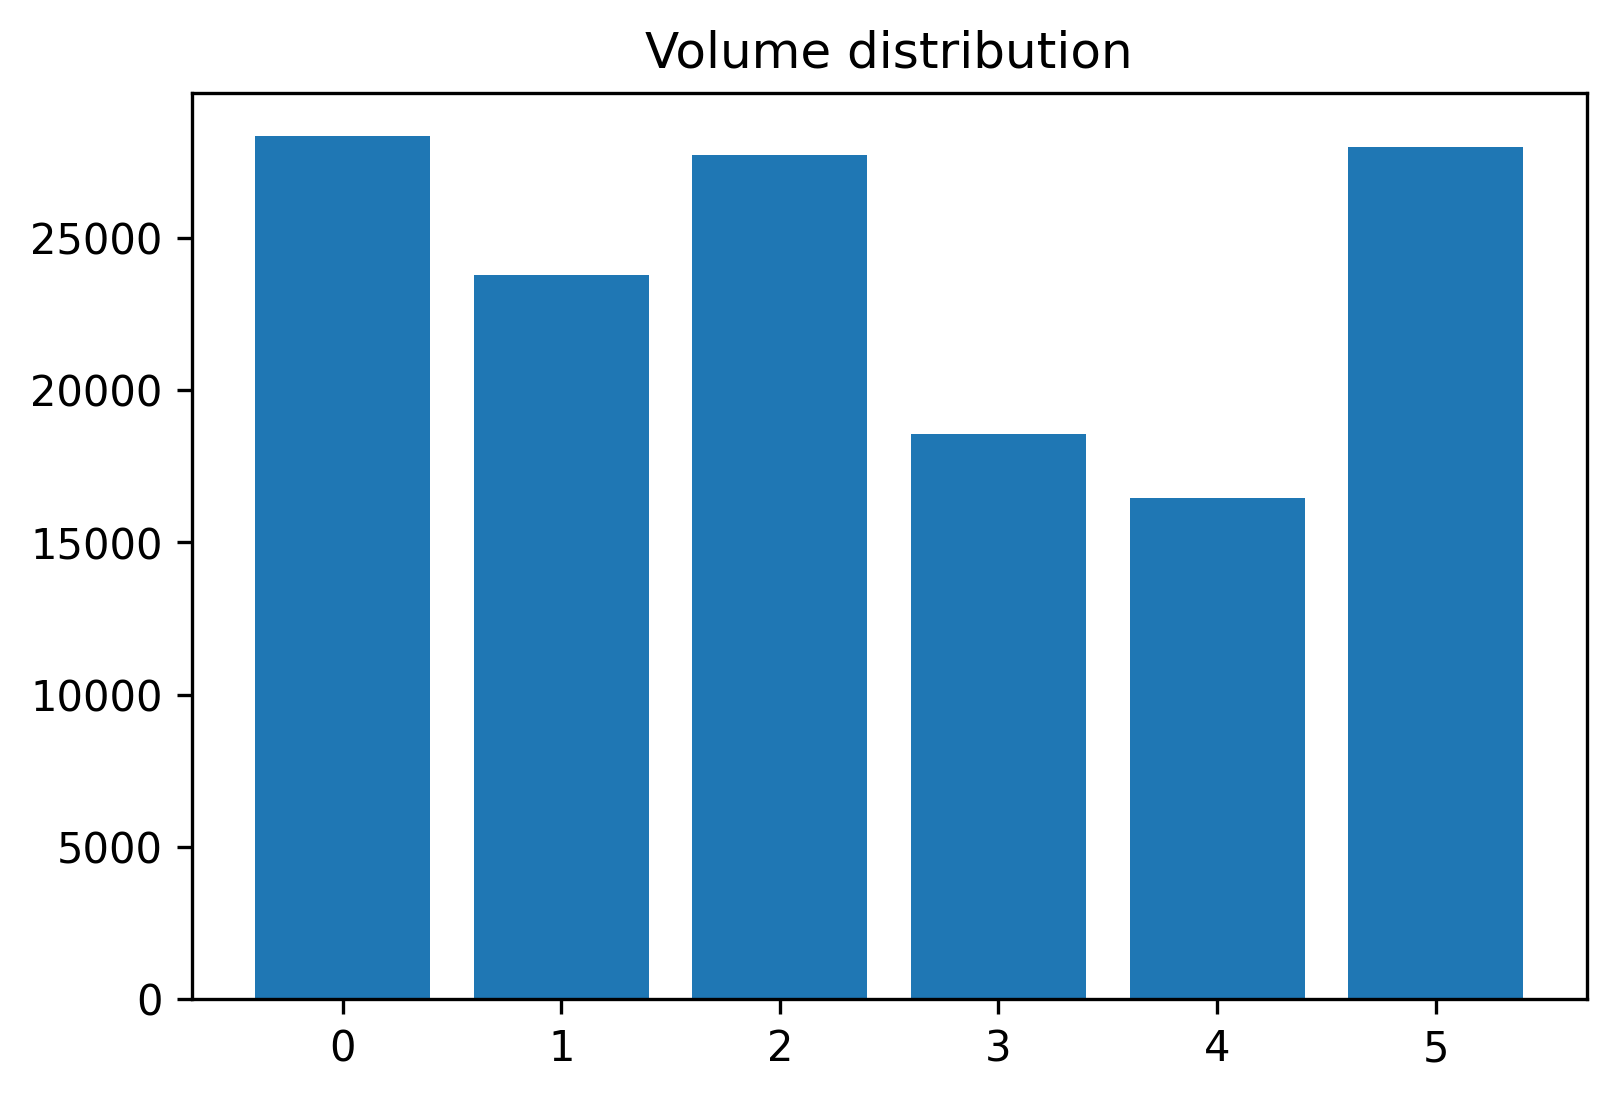

,volume
0,28360
1,23803
2,27732
3,18559
4,16456
5,27987


,volume,% of max
0,28360,100.0
1,23803,83.9
2,27732,97.8
3,18559,65.4
4,16456,58.0
5,27987,98.7


array([0, 1, 2, 3, 4, 5, 6])

In [32]:
masks = zero_small_volume_masks(masks, mask_volume_threshold_of_max)

In [33]:
np.unique(masks)

array([0, 1, 2, 3, 4, 5, 6])

### Save final masks: compacted and without small volume outliers

In [34]:
base_filename = Path(input_file_path).stem
base_filename

'demo'

In [35]:
#np.save(f'{basedir_out}/masks_2d_{base_filename}.npy', masks.astype(np.int8))